In [4]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import random
import numpy as np
import timeit
from tqdm import tqdm

In [22]:
DATA_DIR = "brain_dataset"
BATCH_SIZE = 1024
IMG_SIZE = 64
CHANNELS = 3
INPUT_VECTOR_DIM = 100
FEATURE_MAP_DIM = 64
LR = 2e-4
BETA1 = 0.5
EPOCHS = 120
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
class Discriminator(nn.Module):
    def __init__(self, feature_map_dim, channels):
        super(Discriminator, self).__init__()
        self.conv_1 = nn.Conv2d(channels, feature_map_dim*2, 4, 2, 1, bias=False) #size [128, 32, 32]
        self.conv_2 = nn.Conv2d(feature_map_dim*2, feature_map_dim*4, 4, 2, 1, bias=False) #size [256, 16, 16]
        self.conv_3 = nn.Conv2d(feature_map_dim*4, feature_map_dim*8, 4, 2, 1, bias=False) #size [512, 8, 8]
        self.conv_4 = nn.Conv2d(feature_map_dim*8, feature_map_dim*16, 4, 2, 1, bias=False) #size [1024, 4, 4]
        self.conv_5 = nn.Conv2d(feature_map_dim*16, 1, 4, 1, 0, bias=False) #size [1, 1, 1]
        
        self.leaky_relu = nn.LeakyReLU(0.2)
        
        self.batch_norm_1 = nn.BatchNorm2d(feature_map_dim*4)
        self.batch_norm_2 = nn.BatchNorm2d(feature_map_dim*8)
        self.batch_norm_3 = nn.BatchNorm2d(feature_map_dim*16)

        self.sigmoid = nn.Sigmoid()
        

    def forward(self, inp):
        x = self.conv_1(inp)
        x = self.leaky_relu(x)
        
        x = self.conv_2(x)
        x = self.batch_norm_1(x)
        x = self.leaky_relu(x)
        
        x = self.conv_3(x)
        x = self.batch_norm_2(x)
        x = self.leaky_relu(x)
        
        x = self.conv_4(x)
        x = self.batch_norm_3(x)
        x = self.leaky_relu(x)
        
        x = self.conv_5(x)
        out = self.sigmoid(x)
        
        return out

In [24]:
discriminator = Discriminator(FEATURE_MAP_DIM, CHANNELS).to(device)

x = torch.randn(BATCH_SIZE, CHANNELS, IMG_SIZE, IMG_SIZE).to(device)
dis_out = discriminator(x)
print(dis_out.size())

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_vector_dim, feature_map_dim, channels):
        super(Generator, self).__init__()
        self.convt_1 = nn.ConvTranspose2d(input_vector_dim, feature_map_dim*16, 4, 1, 0, bias=False) #size [1024, 4, 4]
        self.convt_2 = nn.ConvTranspose2d(feature_map_dim*16, feature_map_dim*8, 4, 2, 1, bias=False) #size [512, 8, 8]
        self.convt_3 = nn.ConvTranspose2d(feature_map_dim*8, feature_map_dim*4, 4, 2, 1, bias=False) #size [256, 16, 16]
        self.convt_4 = nn.ConvTranspose2d(feature_map_dim*4, feature_map_dim*2, 4, 2, 1, bias=False) #size [128, 32, 32]
        self.convt_5 = nn.ConvTranspose2d(feature_map_dim*2, channels, 4, 2, 1, bias=False) #size [3, 64, 64]
        
        self.relu = nn.ReLU()
        
        self.batch_norm_1 = nn.BatchNorm2d(feature_map_dim*16)
        self.batch_norm_2 = nn.BatchNorm2d(feature_map_dim*8)
        self.batch_norm_3 = nn.BatchNorm2d(feature_map_dim*4)
        self.batch_norm_4 = nn.BatchNorm2d(feature_map_dim*2)
        
        self.tanh = nn.Tanh()

    def forward(self, inp):
        x = self.convt_1(inp)
        x = self.batch_norm_1(x)
        x = self.relu(x)
        
        x = self.convt_2(x)
        x = self.batch_norm_2(x)
        x = self.relu(x)
        
        x = self.convt_3(x)
        x = self.batch_norm_3(x)
        x = self.relu(x)
        
        x = self.convt_4(x)
        x = self.batch_norm_4(x)
        x = self.relu(x)
        
        x = self.convt_5(x)
        out = self.tanh(x)
        
        return out

In [16]:
generator = Generator(INPUT_VECTOR_DIM, FEATURE_MAP_DIM, CHANNELS).to(device)

noise = torch.randn(BATCH_SIZE, INPUT_VECTOR_DIM, 1, 1, device=device)
gen_out = generator(noise)
print(gen_out.size())

torch.Size([1024, 3, 64, 64])


In [18]:
dataset = ImageFolder(DATA_DIR,
                           transform=transforms.Compose([
                               transforms.Resize(IMG_SIZE),
                               transforms.CenterCrop(IMG_SIZE),
                               transforms.ToTensor(),
                               transforms.Normalize(*((0.5,0.5,0.5),(0.5,0.5,0.5))),
                           ]))


dataloader = DataLoader(dataset, BATCH_SIZE, shuffle=True)

100%|██████████| 1/1 [00:32<00:00, 32.18s/it]


Discriminator Loss EPOCH 1: 0.7540
Generator Loss EPOCH 1: 6.3197


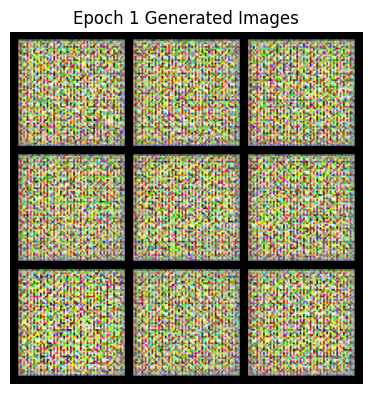

100%|██████████| 1/1 [00:26<00:00, 26.99s/it]


Discriminator Loss EPOCH 2: 1.8775
Generator Loss EPOCH 2: 10.4862


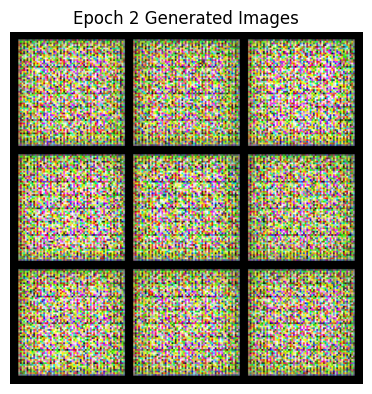

100%|██████████| 2/2 [01:00<00:00, 30.22s/it]

Training Time: 60.54s


In [19]:
criterion = nn.BCELoss()

discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=LR, betas=(BETA1, 0.999))
generator_optimizer = optim.Adam(generator.parameters(), lr=LR, betas=(BETA1, 0.999))

generator.train()
discriminator.train()

start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    generator_running_loss = 0
    discriminator_running_loss = 0
    for idx, data in enumerate(tqdm(dataloader, position=0, leave=True)):
        img_data = data[0].to(device) #size [1024, 3, 64, 64]
        dummy_labels = data[1] #size [1024]
        
        real_labels = torch.full((dummy_labels.size()), 1., dtype=torch.float).to(device) #size [1024]
        fake_labels = torch.full((dummy_labels.size()), 0., dtype=torch.float).to(device)
        noise = torch.randn(dummy_labels.size()[0], INPUT_VECTOR_DIM, 1, 1).to(device) #size [1024, 100, 1, 1]
        
        
        discriminator_real_out = discriminator(img_data).view(-1) #size [1024] .view(-1) to rid unnecessary dimensions
        discriminator_real_loss = criterion(discriminator_real_out, real_labels)
        discriminator.zero_grad()
        discriminator_real_loss.backward()
        
        generator_fake_out = generator(noise) #size [1024, 3, 64, 64]
        discriminator_fake_out = discriminator(generator_fake_out.detach()).view(-1) #detach used because we'll calculate it for a second time
        discriminator_fake_loss = criterion(discriminator_fake_out, fake_labels) 
        discriminator_fake_loss.backward()
        discriminator_running_loss += discriminator_real_loss.item() + discriminator_fake_loss.item()
        discriminator_optimizer.step()

        discriminator_fake_out = discriminator(generator_fake_out).view(-1) #calculated it for a second time. So that we won't have to backward graphs a second time
        generator_loss = criterion(discriminator_fake_out, real_labels)
        generator_running_loss += generator_loss.item()
        generator.zero_grad()
        generator_loss.backward()
        generator_optimizer.step()
        
    
    discriminator_loss = discriminator_running_loss / 2*(idx + 1)
    generator_loss = generator_running_loss / (idx + 1)
    
    print(f"Discriminator Loss EPOCH {epoch+1}: {discriminator_loss:.4f}")
    print(f"Generator Loss EPOCH {epoch+1}: {generator_loss:.4f}")
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title(f"Epoch {epoch+1} Generated Images")
    plt.imshow(np.transpose(vutils.make_grid(generator_fake_out[:9], padding=5, normalize=True, nrow=3).cpu(),(1,2,0)))
    plt.show()
    
stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

In [20]:
torch.cuda.empty_cache()

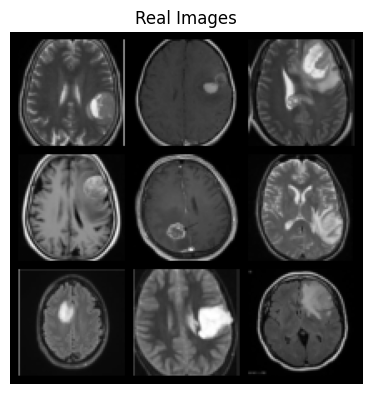

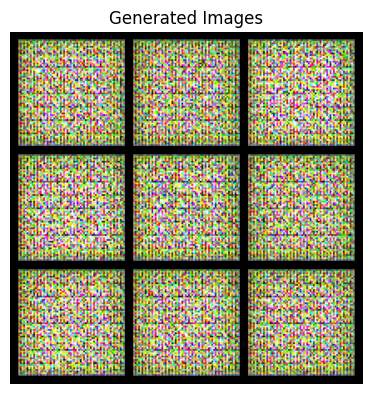

In [21]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:9], padding=5, normalize=True, nrow=3).cpu(),(1,2,0)))

plt.figure(figsize=(10,10))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(generator_fake_out[:9], padding=5, normalize=True, nrow=3).cpu(),(1,2,0)))
plt.show()


In [ ]:
noise = torch.randn(dummy_labels.size()[0], INPUT_VECTOR_DIM, 1, 1).to(device)
generator_fake_out = generator(noise)

plt.imshow(generator_fake_out[5].detach().cpu().permute(1, 2, 0))